In [1]:
import collections
import math
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [3]:
folder_path = "C:/Users/Kieran/Documents/Master Thesis Data/Datasets/ChangeCoords"

dataframes = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)
        
data = pd.concat(dataframes, ignore_index=True)
data = data.drop(columns = ['frame_number'])
data

,"('nose', 'x')","('nose', 'y')","('nose', 'likelihood')","('H1R', 'x')","('H1R', 'y')","('H1R', 'likelihood')","('H2R', 'x')","('H2R', 'y')","('H2R', 'likelihood')","('H1L', 'x')",...,"('tail', 'x')","('tail', 'y')","('tail', 'likelihood')","('S2', 'x')","('S2', 'y')","('S2', 'likelihood')","('S1', 'x')","('S1', 'y')","('S1', 'likelihood')",mouse_no
0,0.000000,0.000000,0.999969,0.000000,0.000000,0.999760,0.000000,0.000000,0.996968,0.000000,...,0.000000,0.000000,0.998689,0.000000,0.000000,0.994912,0.000000,0.000000,0.995648,11.4
1,0.444275,2.021118,0.999950,0.536194,1.981354,0.999568,4.448181,4.355835,0.997916,0.535675,...,1.670120,0.212906,0.999059,0.595001,0.076477,0.996069,3.630341,2.596069,0.993003,11.4
2,0.439880,3.892548,0.999945,0.945496,3.524902,0.999638,1.928741,0.726379,0.999153,0.970154,...,0.798141,1.392517,0.999419,2.681183,0.000000,0.986211,3.590607,2.148987,0.987800,11.4
3,7.703064,0.000000,0.999765,5.919373,0.000000,0.999534,4.751312,0.000000,0.999468,6.556610,...,1.855469,1.921738,0.999285,2.977997,0.041992,0.981083,3.765533,2.638062,0.994152,11.4
4,17.169312,0.000000,0.999855,20.999176,0.000000,0.999252,17.283508,0.000000,0.998945,13.850159,...,0.000000,4.927261,0.999156,0.000000,0.000000,0.983985,1.823181,0.067993,0.995609,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102495,1.339661,2.253326,0.999232,3.207214,5.388489,0.999924,3.782471,2.128571,0.999492,8.150452,...,0.582886,0.000000,0.999563,0.424469,0.375305,0.998793,4.226929,0.000000,0.998882,88.3
1102496,1.342590,4.823639,0.999680,1.945129,3.831635,0.999842,0.461548,1.584595,0.999562,3.117249,...,0.348389,0.000000,0.999529,0.385101,0.000000,0.998716,0.232422,-0.049561,0.998840,88.3
1102497,12.412659,0.000000,0.999622,9.379395,0.000000,0.999950,6.598083,2.645782,0.999656,7.575562,...,-0.155914,-1.260956,0.999215,0.496552,-0.301575,0.999035,0.308044,0.000000,0.998980,88.3
1102498,0.000000,0.000000,0.999570,0.000000,0.000000,0.999939,0.000000,0.000000,0.999616,0.000000,...,0.000000,-0.214752,0.999225,0.000000,-0.073730,0.998865,0.000000,0.000000,0.998603,88.3


In [4]:
dropout_prob   = 0.5
embedding_size = 32
epoch_num      = 10
hidden_size    = 16
layer_num      = 2
learning_rate  = 1e-3
seq_size       = 25 #25 frames is equal to 1 second of video, maybe use 50?

In [5]:
class SeqDataset(Dataset):
    def __init__(self, device, seq_size, dataframe):
        super(SeqDataset, self).__init__()
        self.device    = device
        self.seq_size  = seq_size
        self.dataframe = dataframe
        self.target_data = dataframe.filter(regex='x|y')

    def __len__(self):
        return len(self.dataframe) - self.seq_size - 1

    def __getitem__(self, idx):
        in_seq = torch.tensor(self.target_data.iloc[idx:idx + self.seq_size].values, dtype=torch.float, device=self.device)
        target_seq = torch.tensor(self.target_data.iloc[idx + 1:idx + self.seq_size + 1].values, dtype=torch.float, device=self.device)
        return in_seq, target_seq

In [6]:
# Split the data into train, validation, and test using the full video sizes (so that videos are not split into different sets)
train_data, test_data = train_test_split(data, test_size= 11250*int(0.2*98), shuffle=False)
n_train_vids = len(train_data)/11250
train_data, val_data = train_test_split(train_data, test_size = 11250 * int(0.1 * n_train_vids), shuffle=False)

# Create SeqDataset instances for the train, validation, and test sets
train_dataset = SeqDataset(device, seq_size, train_data)
val_dataset = SeqDataset(device, seq_size, val_data)
test_dataset = SeqDataset(device, seq_size, test_data)

# Create DataLoader instances for batching
batch_size = 64  # Adjust to your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class Model(nn.Module):
    def __init__(self, dropout_prob, hidden_size, layer_num, input_size, output_size):
        super(Model, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru       = nn.GRU(input_size, hidden_size, layer_num, batch_first=True, dropout=dropout_prob)
        self.linear    = nn.Linear(hidden_size, output_size)

    def forward(self, in_sequence, hidden_state=None):
#         embedding_seq            = self.embedding(in_sequence)
        hidden_seq, hidden_state = self.gru(in_sequence, hidden_state)
        out_seq                  = self.linear(hidden_seq)
        return out_seq, hidden_state
    
    def draw(self, in_sequence, logit_temp=1.0):
        out_seq, _  = self(in_sequence)
        prob_dist   = torch.softmax(out_seq[0, -1] / logit_temp, 0)
        rand_sample = torch.multinomial(prob_dist, 1).item()                   
        return rand_sample

In [8]:
input_size = next(iter(train_loader))[0].size(-1)
print("Input size:", input_size)
output_size = next(iter(train_loader))[1].size(-1)
print("Output size:", output_size)
model = Model(dropout_prob, hidden_size, layer_num, input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

Input size: 28
Output size: 28


In [9]:
min_loss = float("inf")

for epoch in range(epoch_num):
    
    model.train()
    train_loss = 0.0
    
    for in_seq, target_seq in tqdm(train_loader, desc=f"Epoch {epoch}/{epoch_num}"):
        out_seq, _  = model(in_seq)
        loss        = criterion(out_seq, target_seq)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss       /= len(train_loader)
    # train_perplexity  = np.exp(train_loss)
    print(f"Train loss: {train_loss:.4f}")

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for in_seq, target_seq in val_loader:
            out_seq, _  = model(in_seq)
            loss        = criterion(out_seq, target_seq)
            val_loss   += loss.item()

    val_loss       /= len(val_loader)
    # val_perplexity  = np.exp(val_loss)
    print(f"Val loss: {val_loss:.4f}")

    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), "C:/Users/Kieran/Documents/Master Thesis Data/Models/model_cc_dropped_cols.pt")

Epoch 0/10: 100%|████████████████████████████████████████████████████████████████| 12656/12656 [04:35<00:00, 45.97it/s]


Train loss: 129.6911
Val loss: 228.3385


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████| 12656/12656 [04:35<00:00, 45.89it/s]


Train loss: 128.1388
Val loss: 228.5120


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████| 12656/12656 [04:36<00:00, 45.84it/s]


Train loss: 127.9128
Val loss: 229.7161


Epoch 3/10:  27%|█████████████████▋                                               | 3441/12656 [01:15<03:21, 45.74it/s]


KeyboardInterrupt: 

In [10]:
model.load_state_dict(torch.load("C:/Users/Kieran/Documents/Master Thesis Data/Models/change_coords.pt"))
model.eval

<bound method Module.eval of Model(
  (gru): GRU(43, 16, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=16, out_features=28, bias=True)
)>

In [11]:
test_loss = 0.0

for in_seq, target_seq in tqdm(test_loader):
    out_seq, _ = model(in_seq)
    loss = criterion(out_seq, target_seq)
    test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test loss: {test_loss:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 3340/3340 [00:38<00:00, 86.82it/s]

Test loss: 107.8879


In [ ]:
# model.load_state_dict(torch.load("C:/Users/Kieran/Documents/Master Thesis Data/Models/model_cc_dropped_cols.pt"))
model.eval

In [ ]:
test_loss = 0.0

for in_seq, target_seq in tqdm(test_loader):
    out_seq, _ = model(in_seq)
    loss = criterion(out_seq, target_seq)
    test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test loss: {test_loss:.4f}")

tensor(158.5428, device='cuda:0', grad_fn=<MseLossBackward0>)


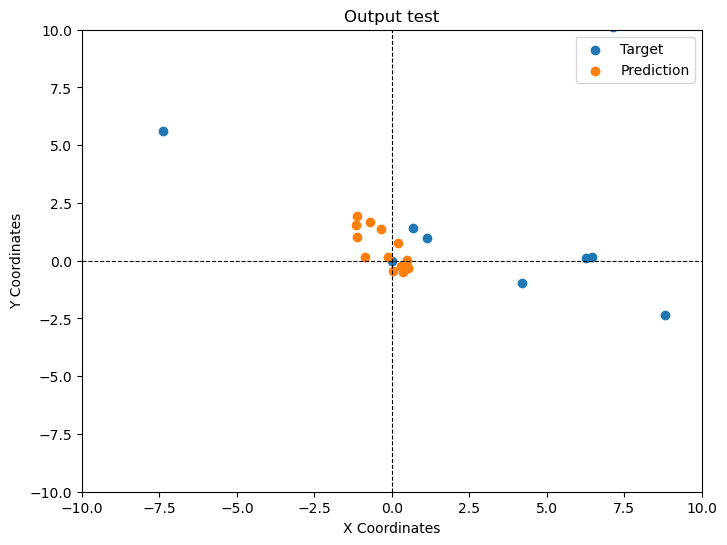

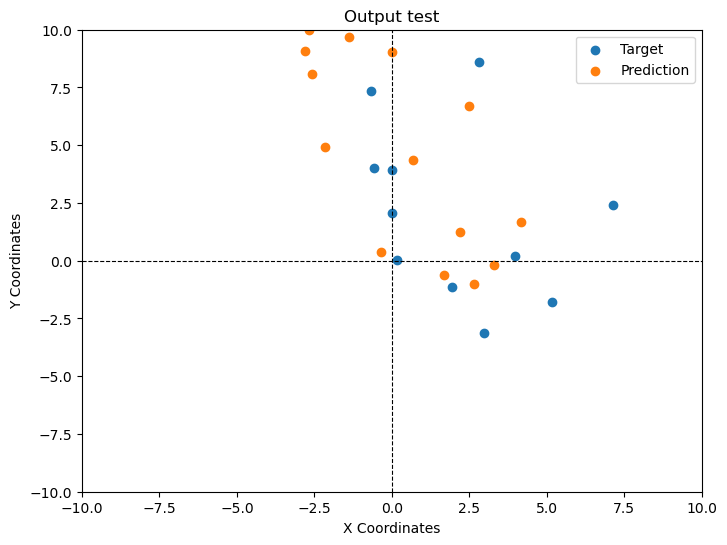

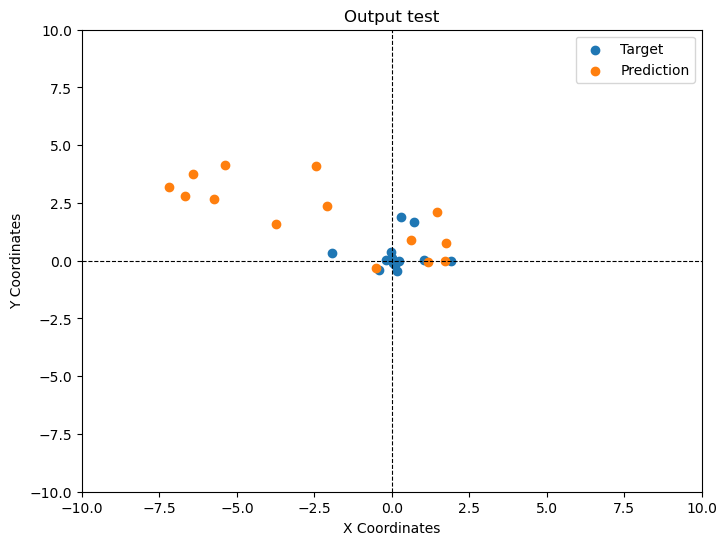

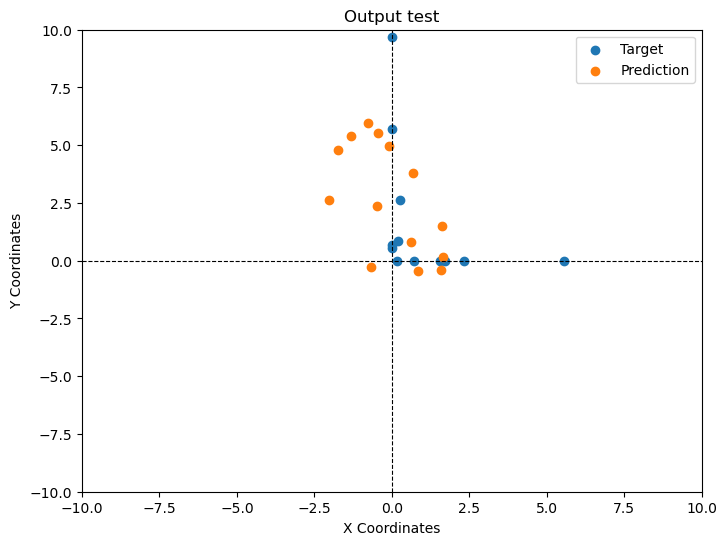

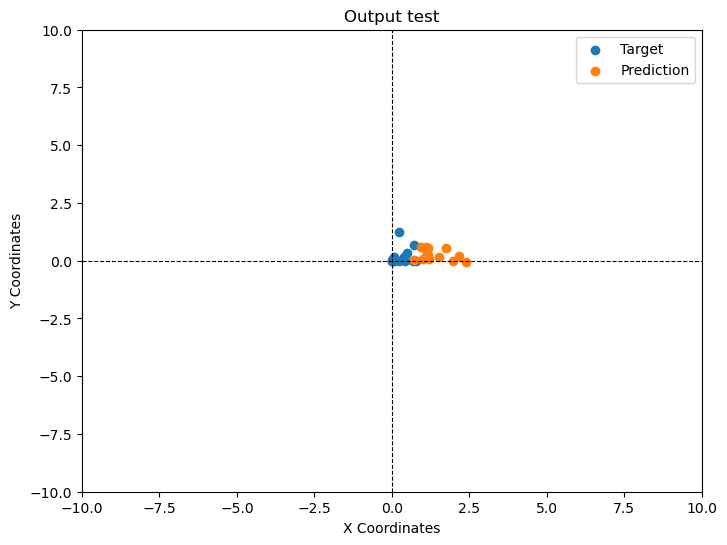

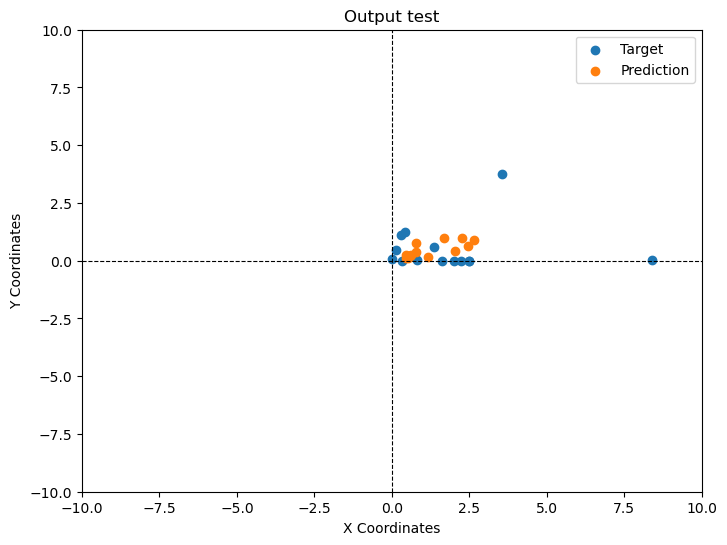

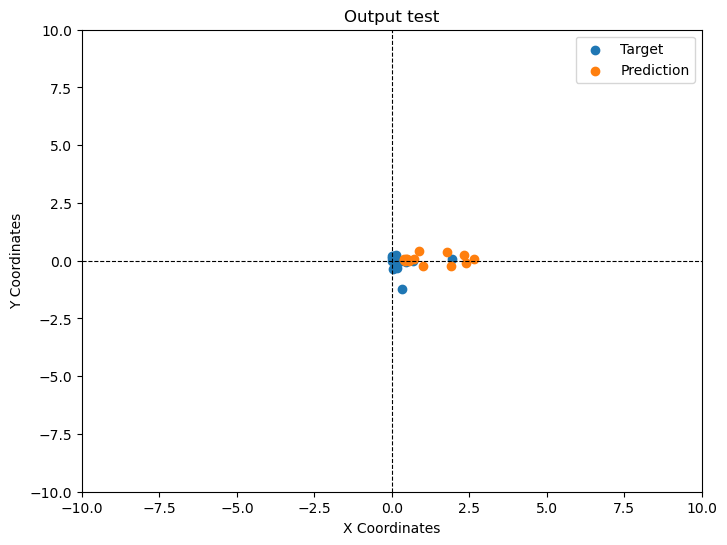

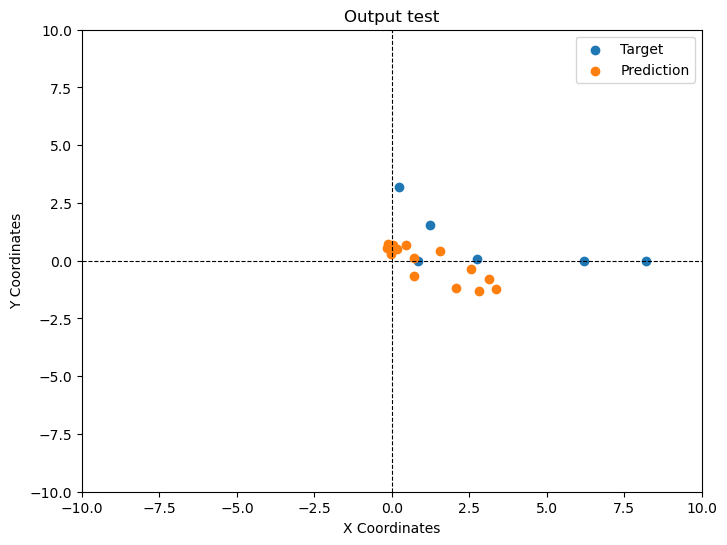

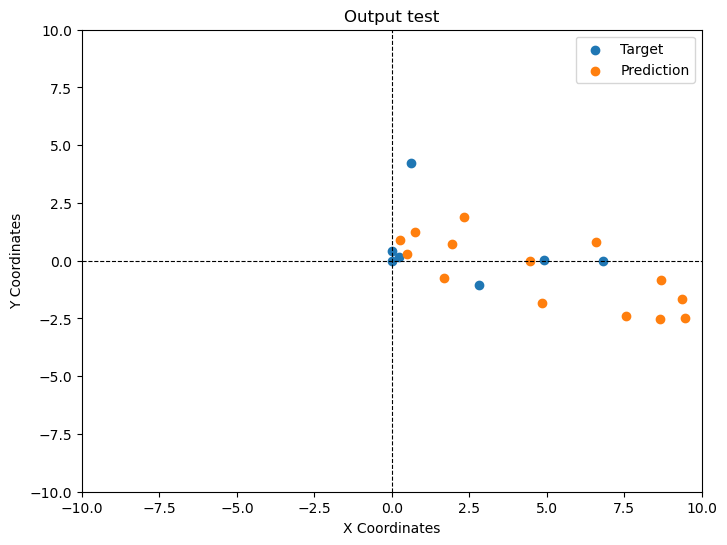

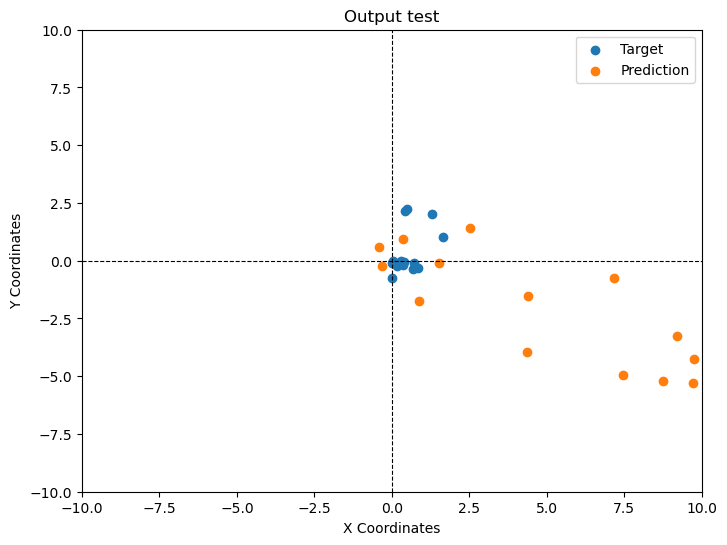

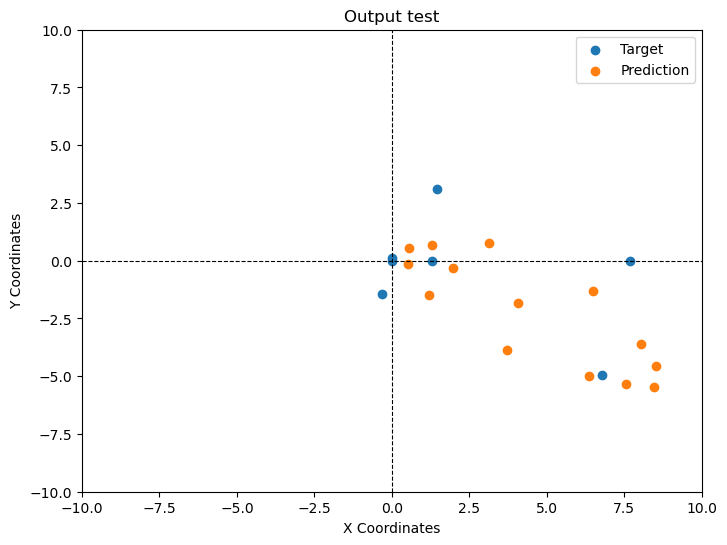

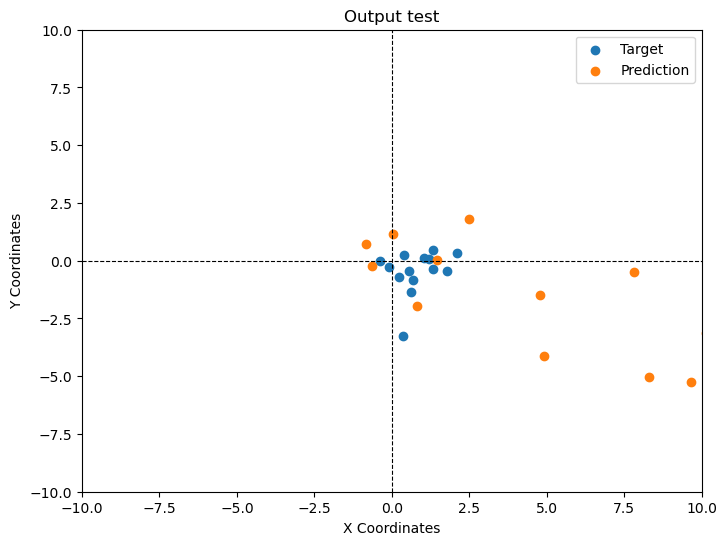

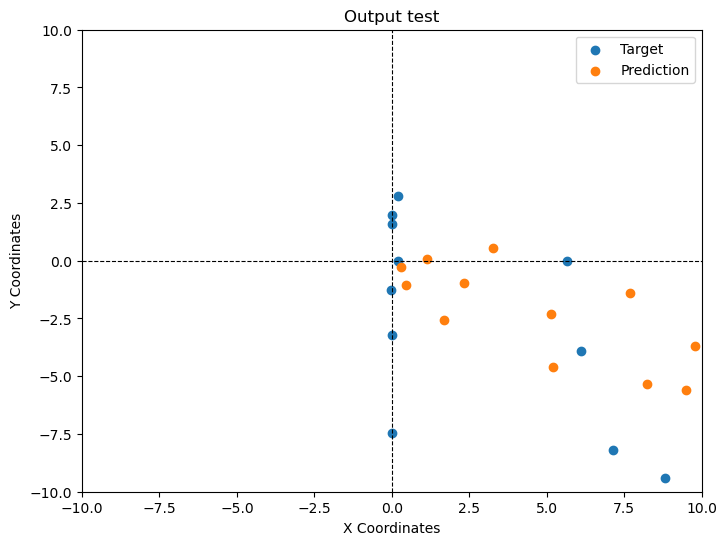

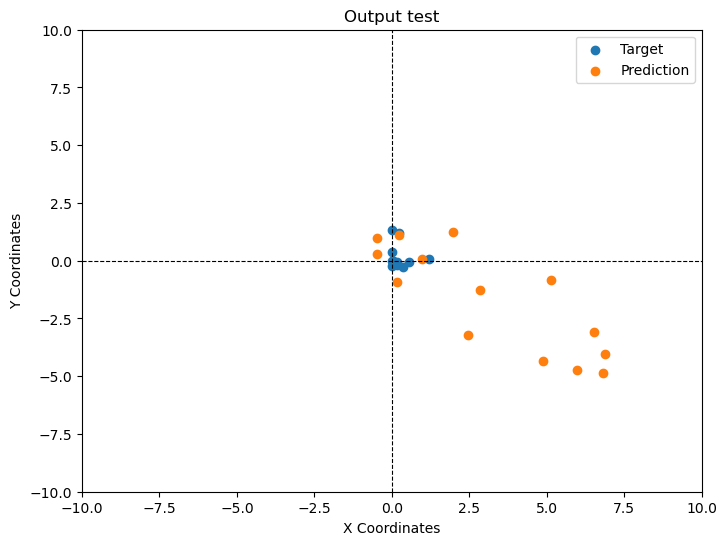

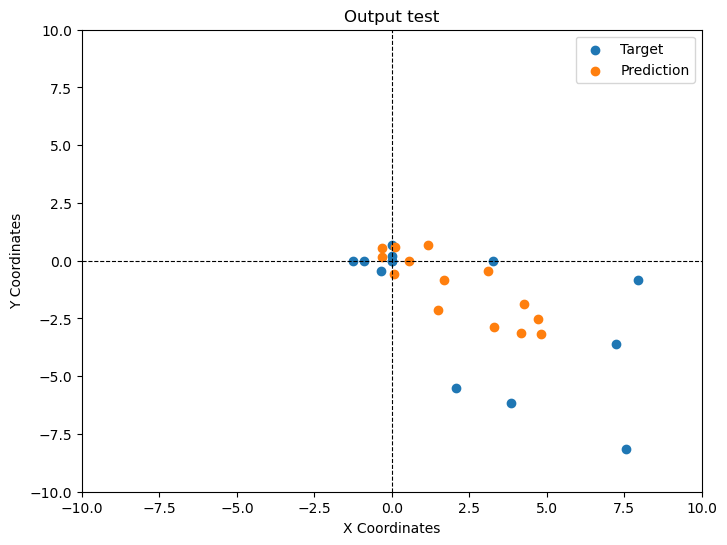

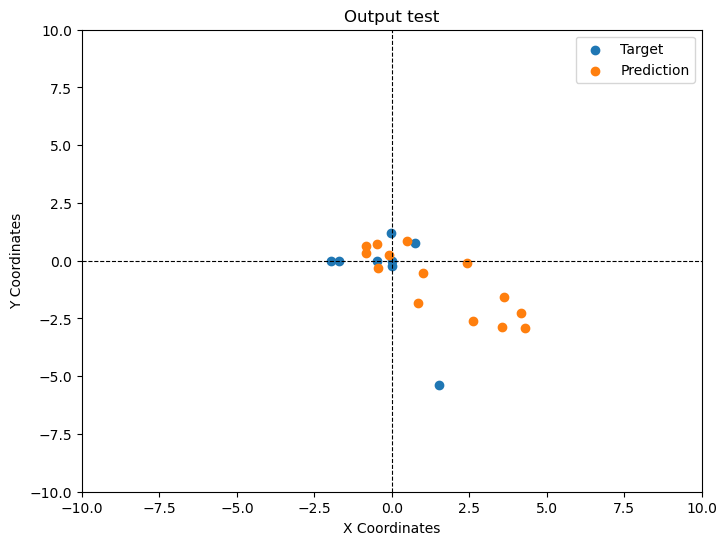

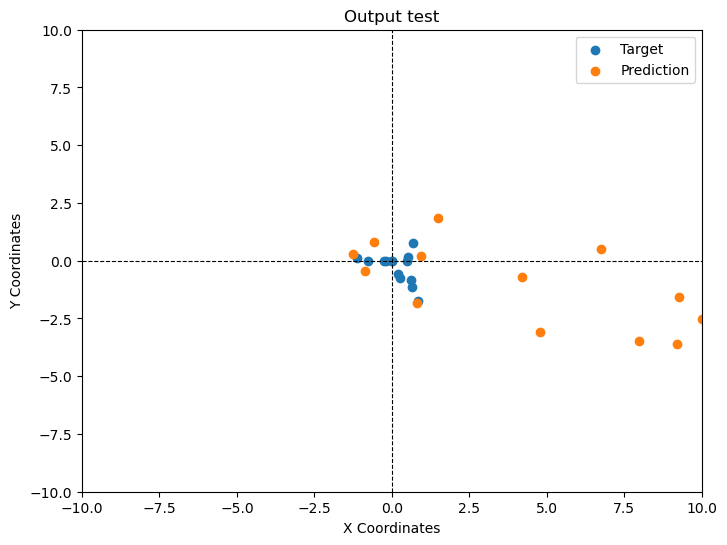

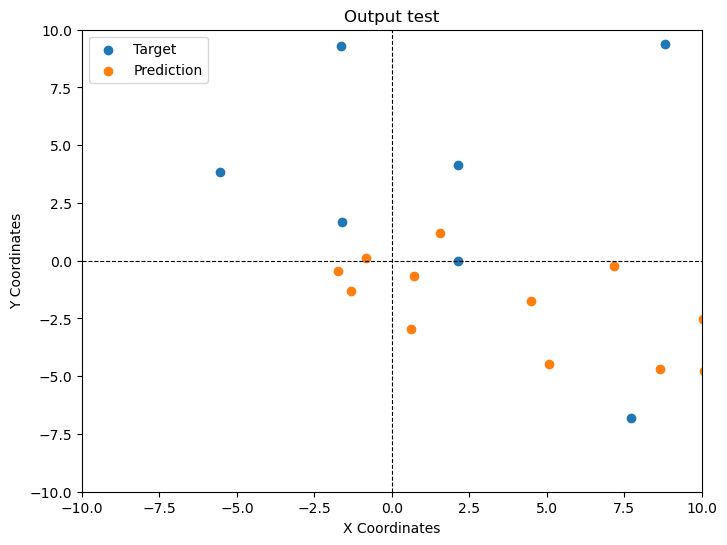

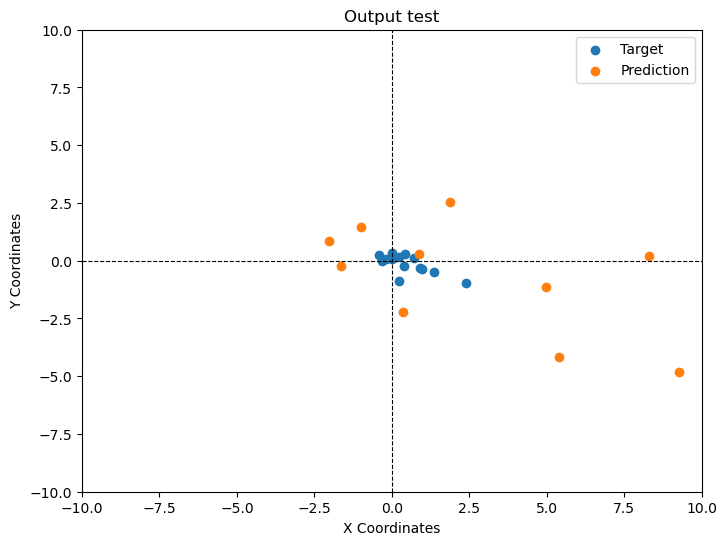

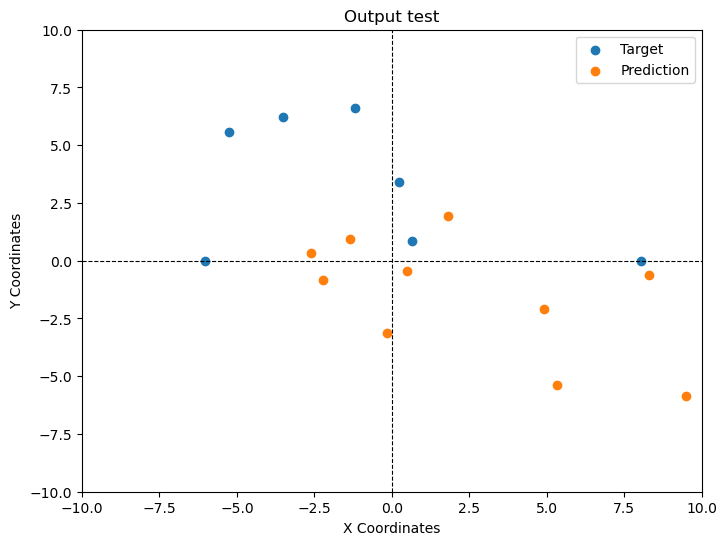

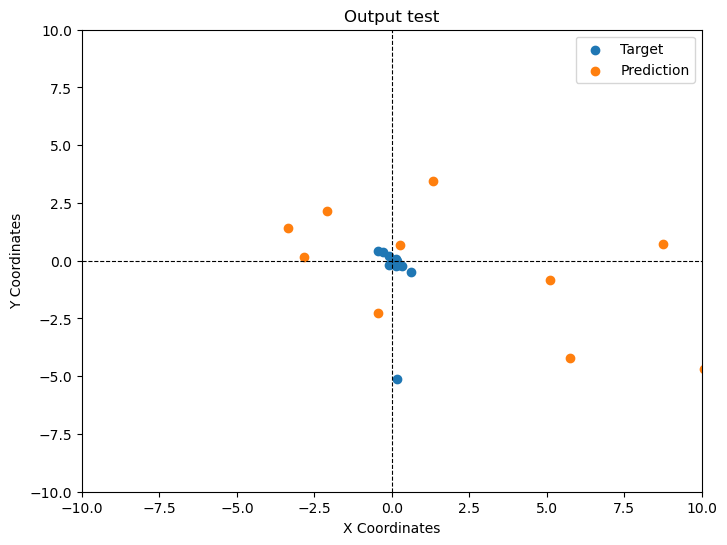

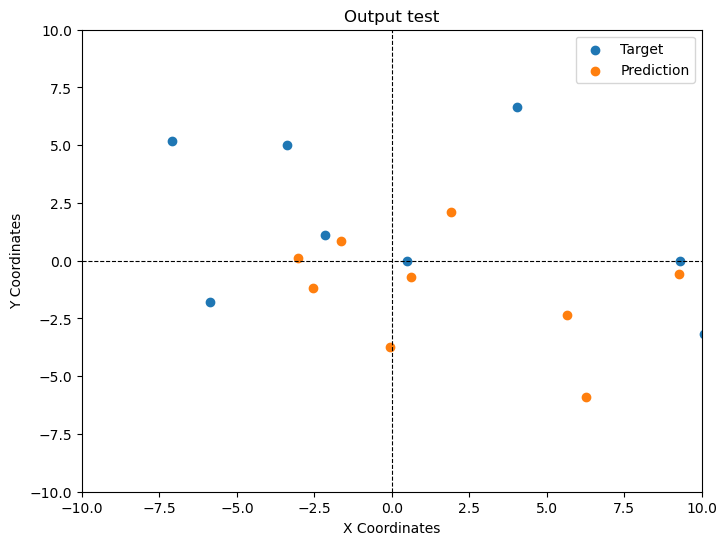

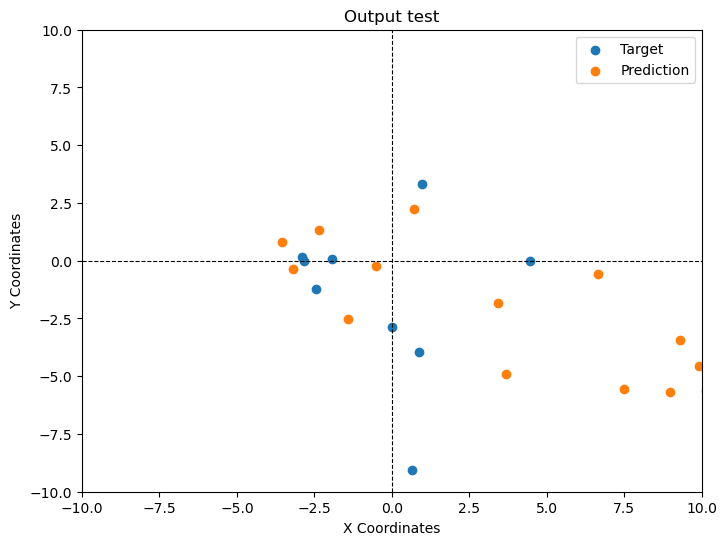

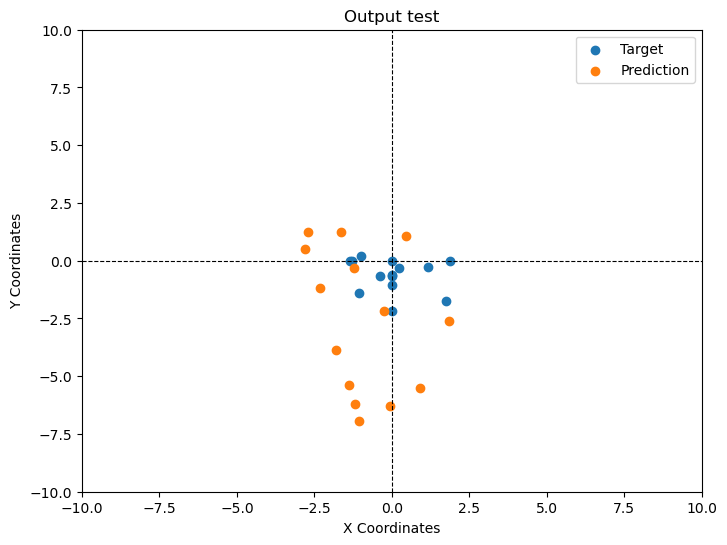

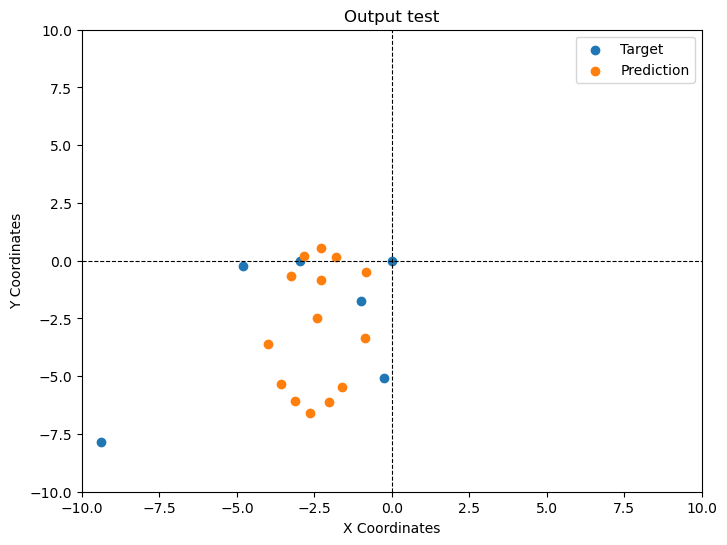

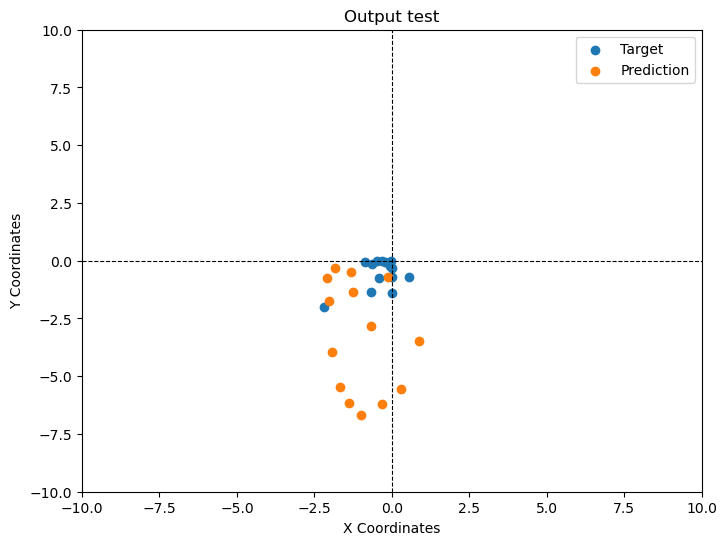

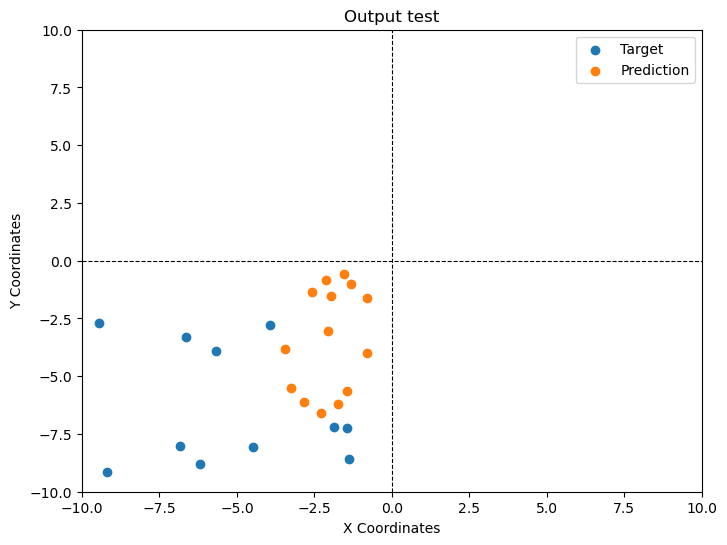

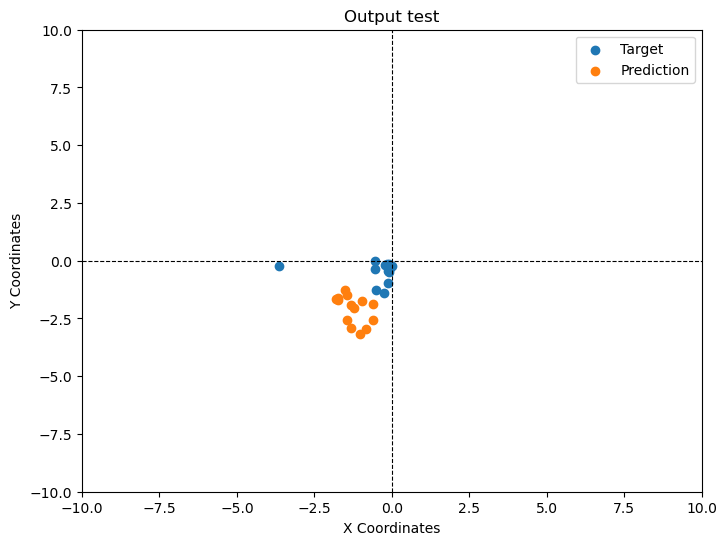

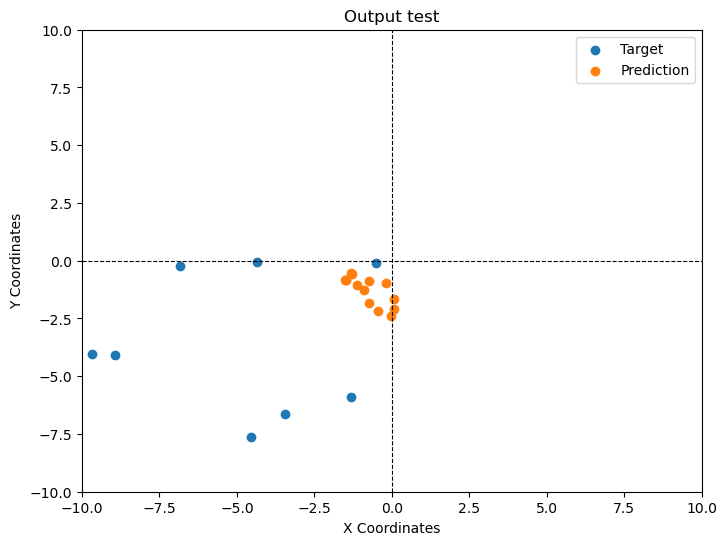

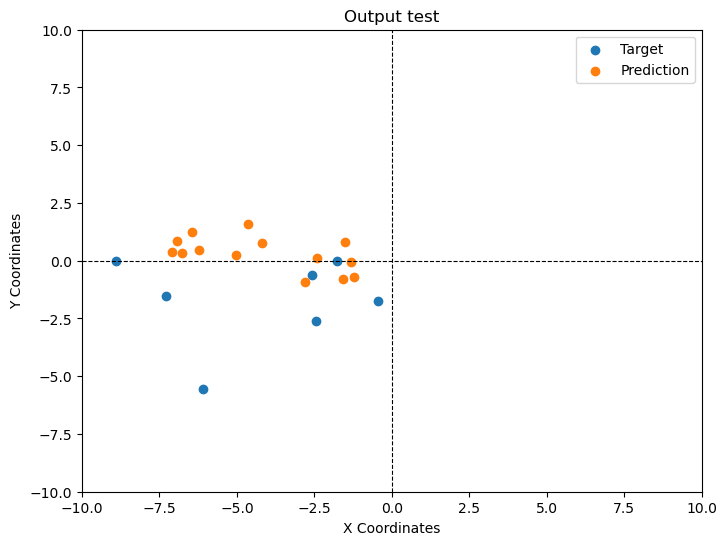

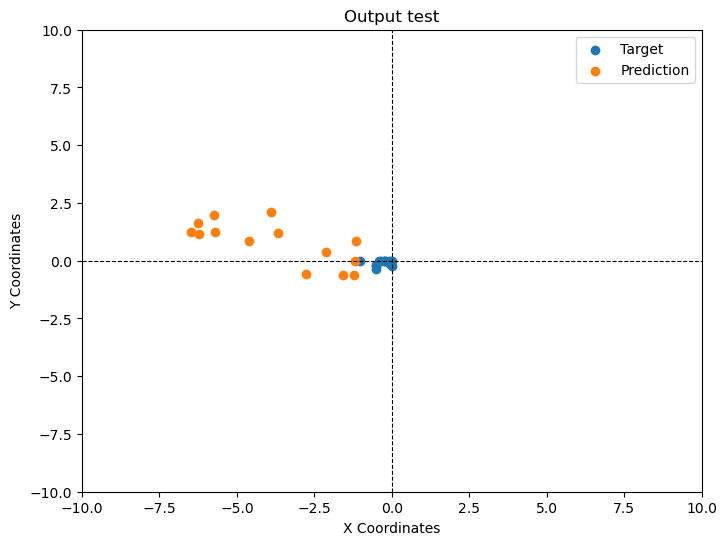

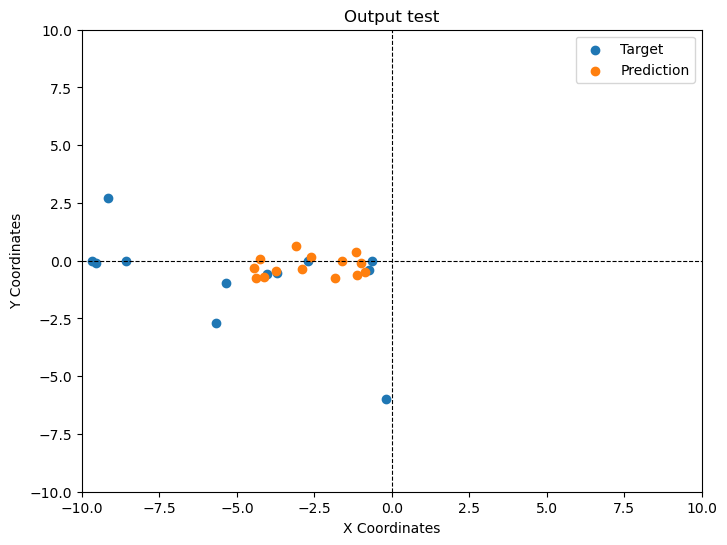

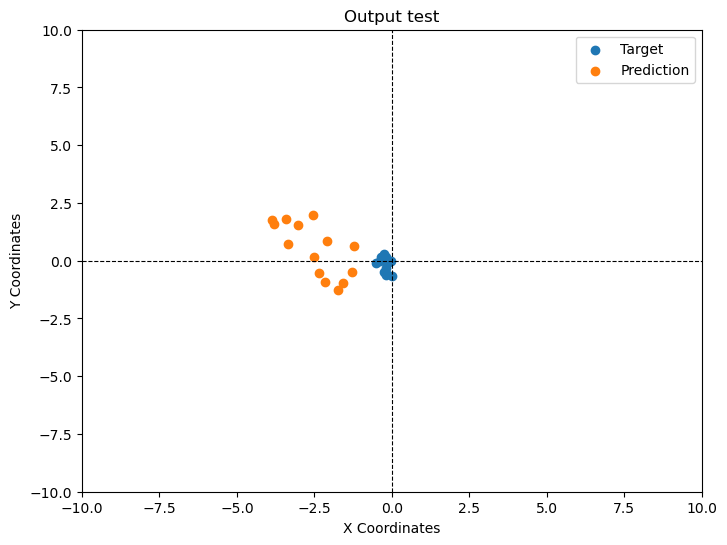

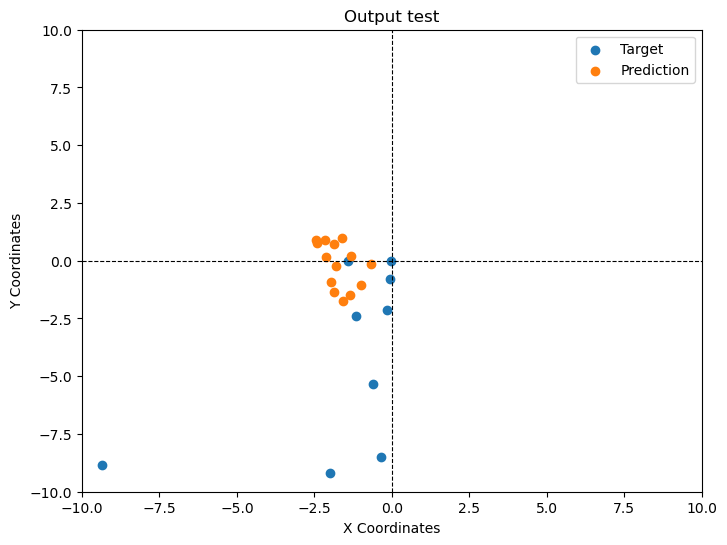

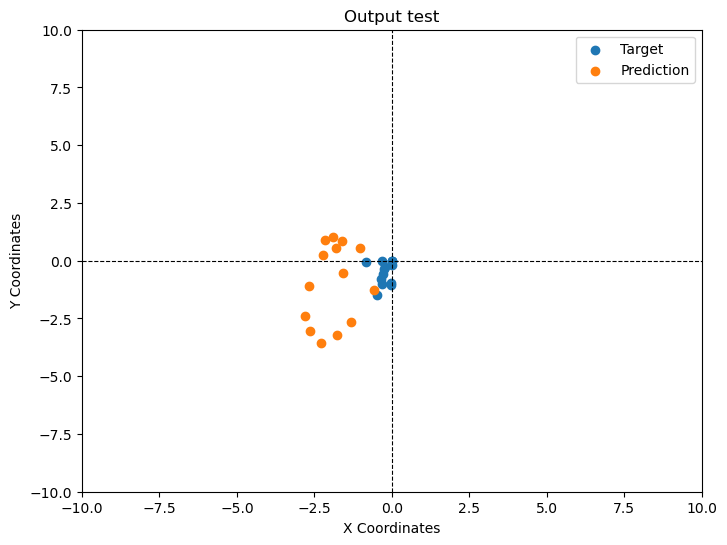

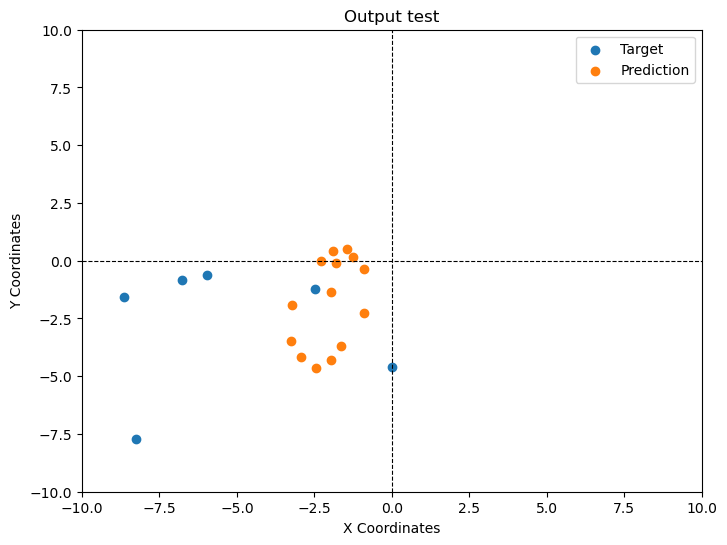

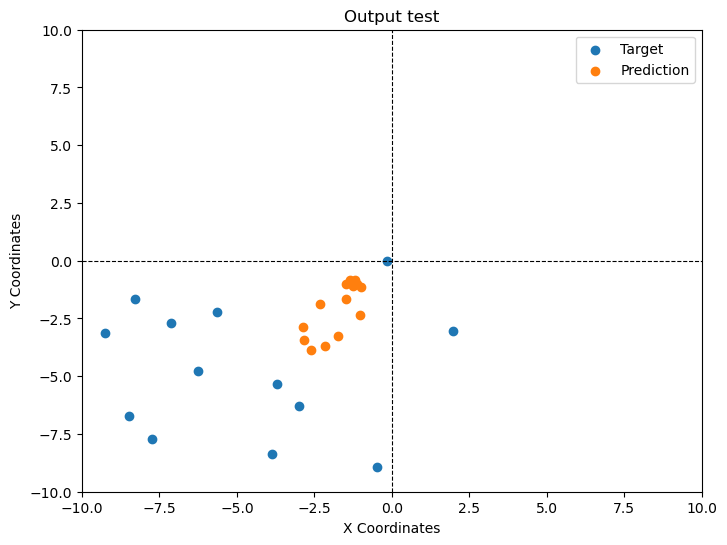

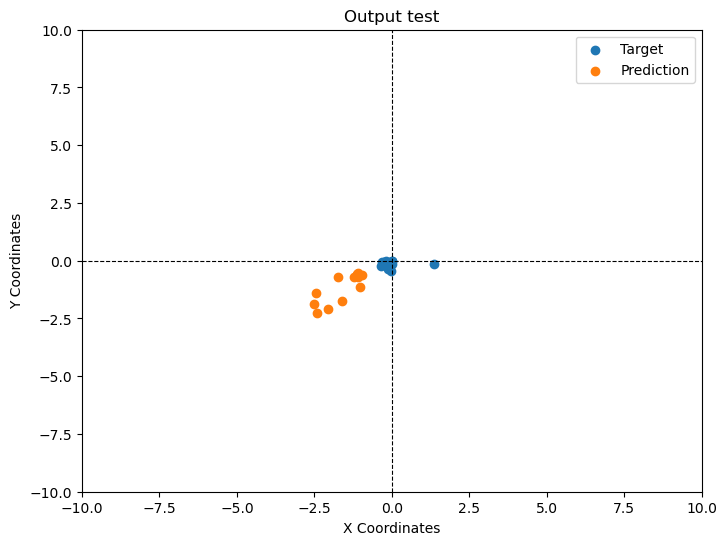

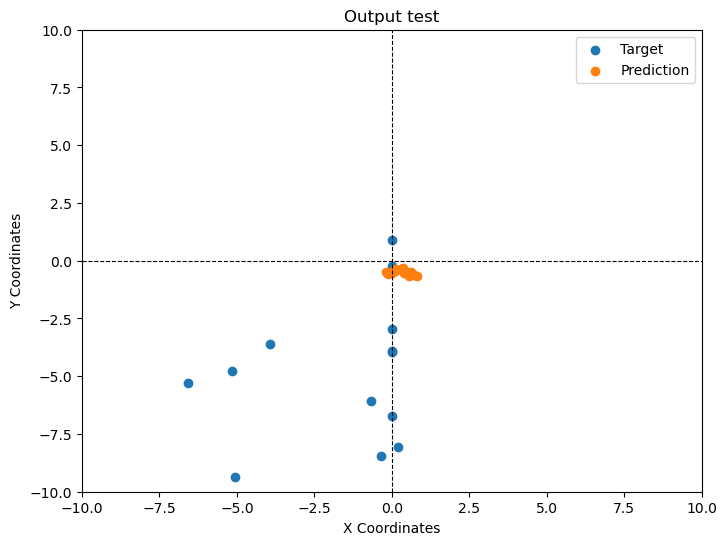

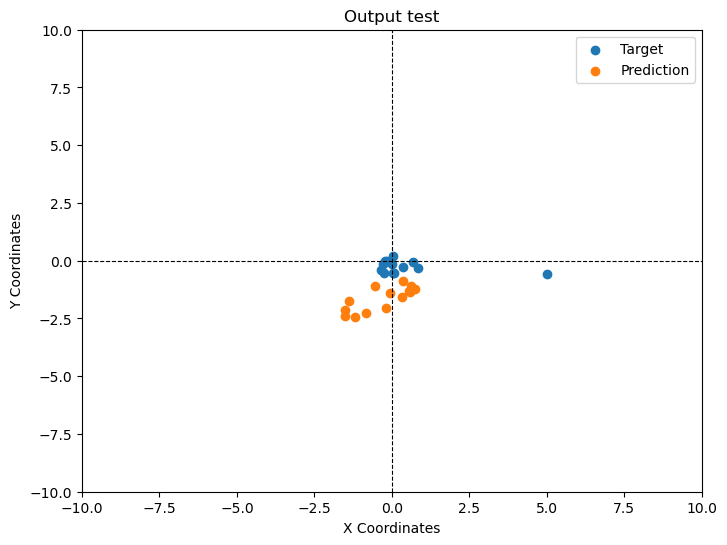

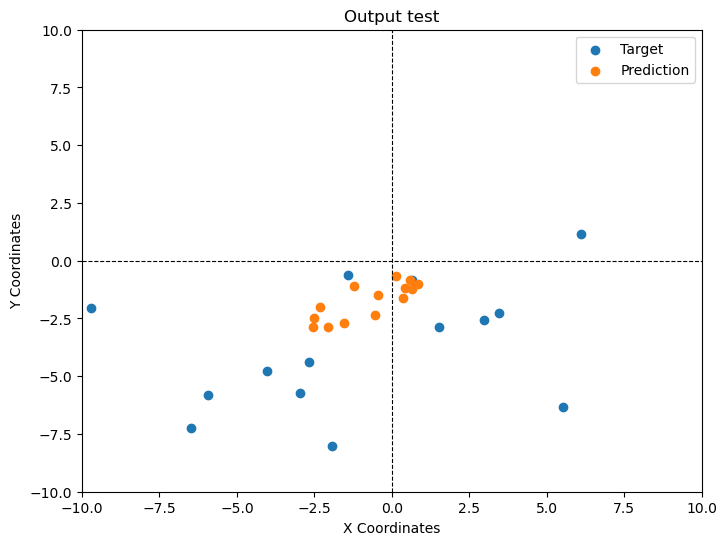

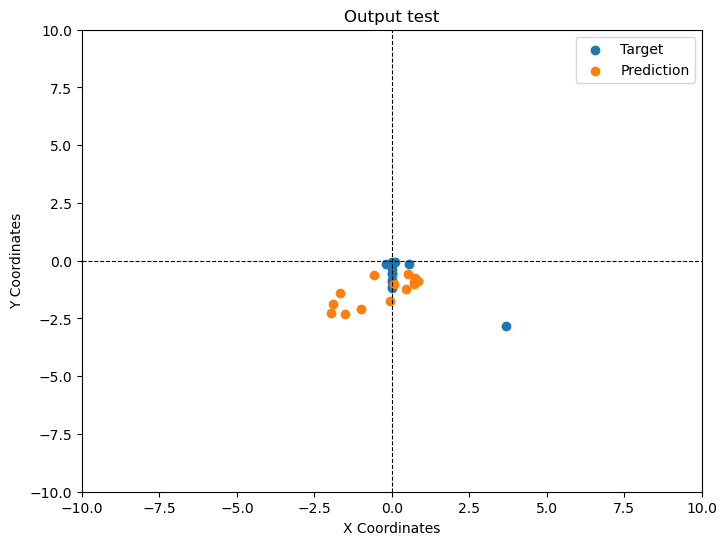

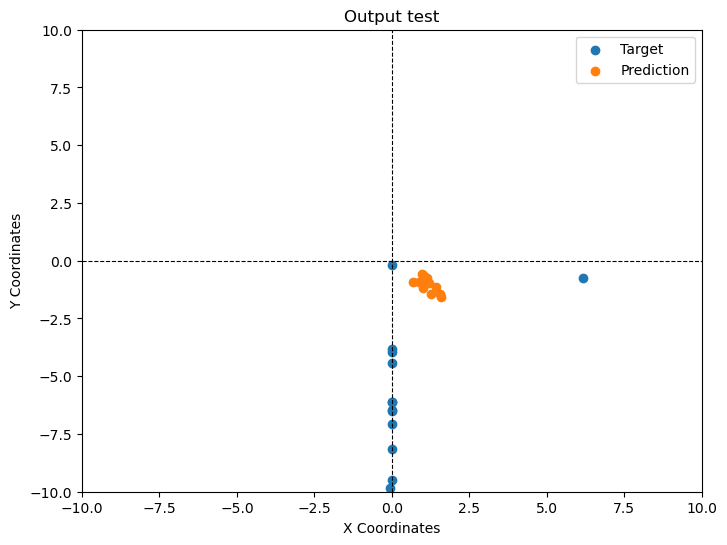

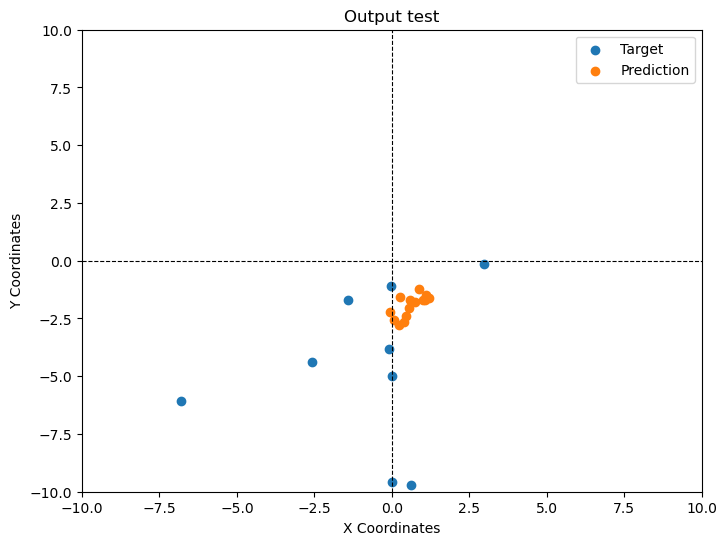

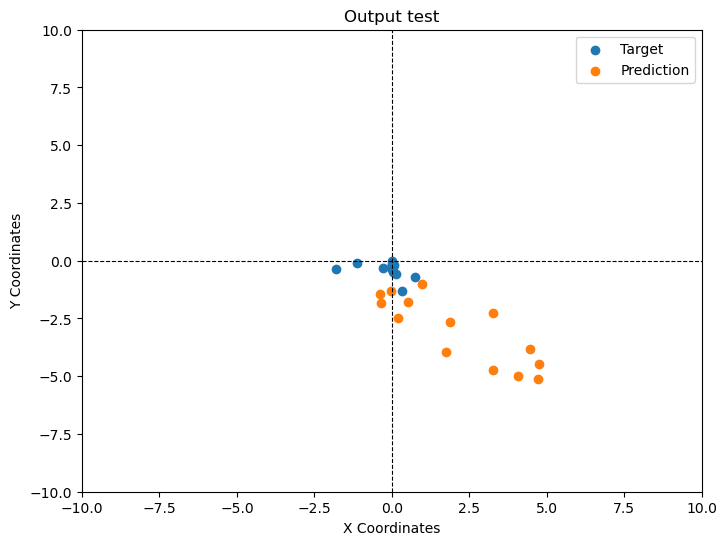

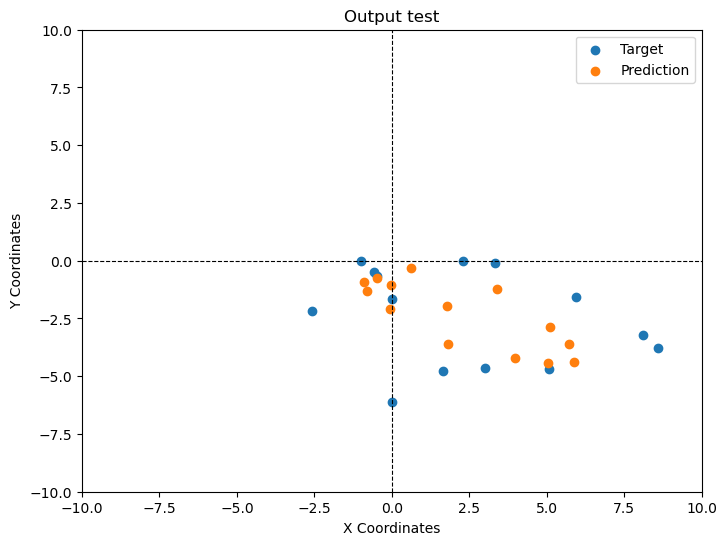

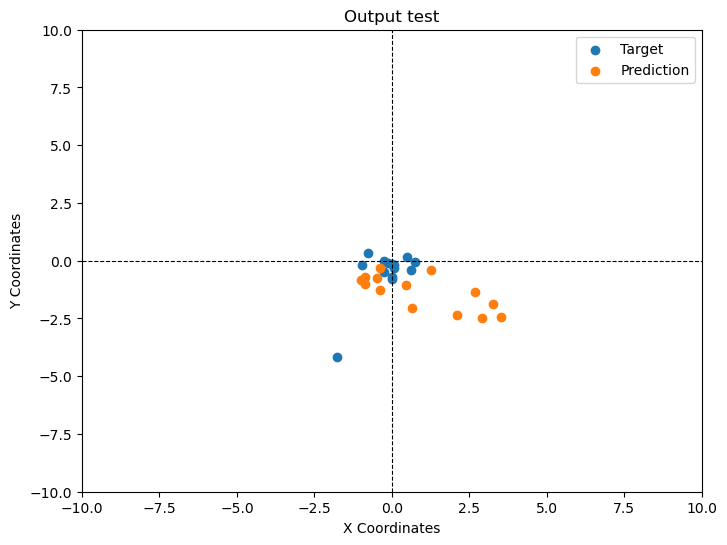

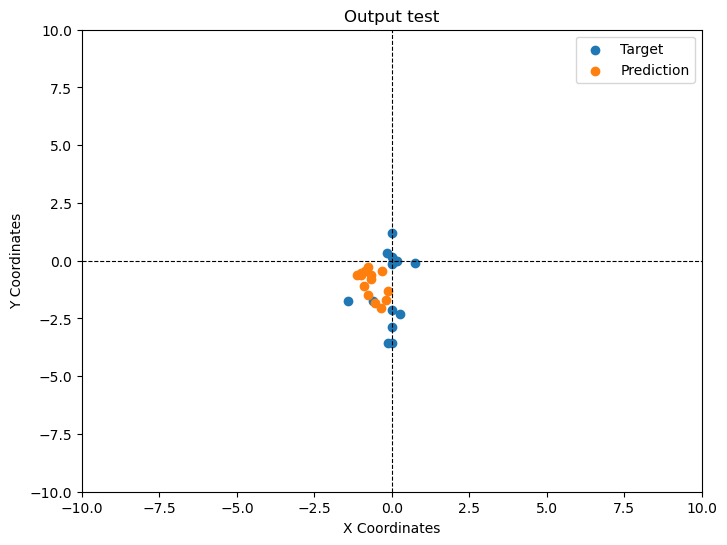

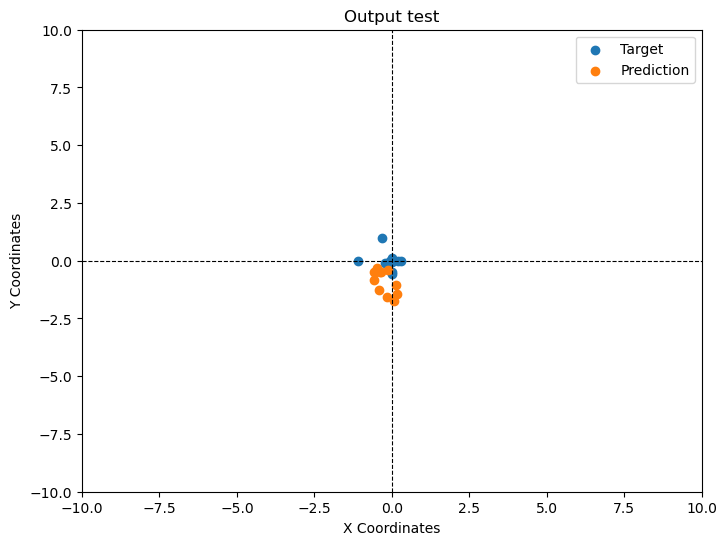

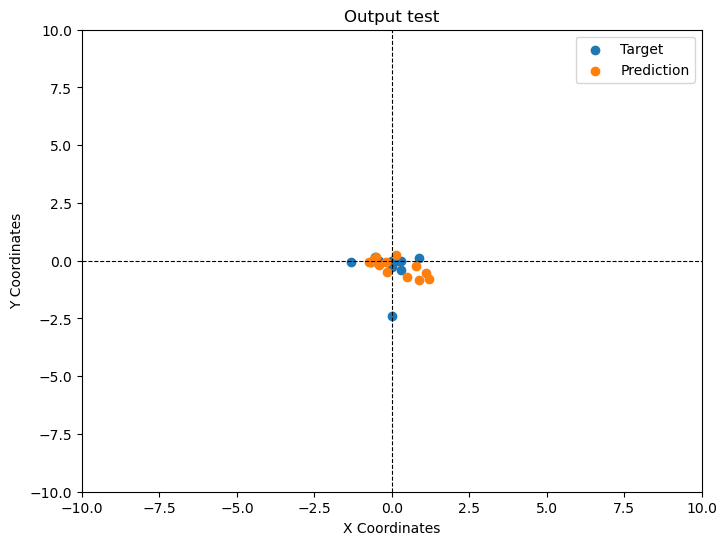

In [17]:
for in_seq, target_seq in test_loader:
    out_seq, _ = model(in_seq)
    loss = criterion(out_seq, target_seq)
    print(loss)

    for i in range(0, 50):
        x_coord = target_seq.cpu()[i, -1][::2]
        y_coord = target_seq.cpu()[i, -1][1::2]
        x_coord_pred = out_seq.cpu().detach().numpy()[i, -1][::2]
        y_coord_pred = out_seq.cpu().detach().numpy()[i, -1][1::2]


        plt.figure(figsize=(8,6))
        plt.scatter(x_coord, y_coord, label = "Target")
        plt.scatter(x_coord_pred, y_coord_pred, label = "Prediction")
        plt.xlabel('X Coordinates')
        plt.ylabel('Y Coordinates')
        plt.title("Output test")
        plt.legend()
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
        plt.show()
    break